In [1]:
import numpy as np

from pandas import DataFrame
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import pearsonr, mstats
from scipy.integrate import dblquad, quad
from scipy.interpolate import InterpolatedUnivariateSpline

from statsmodels.stats.stattools import jarque_bera

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = DataFrame.from_csv("./testosterone_levels.csv")

In [3]:
testosterones = [p.Testosterone for _, p in data.groupby("Person")]

In [4]:
# whole population
mean_std = np.array([[t.mean(), t.std()] for t in testosterones])
cv = (mean_std[:, 1] / mean_std[:, 0]) * 100

# gender specific population
gender = data.groupby("Person").first()['F1']
male = data[data['F1'] == 1]
female = data[data['F1'] == 2]
male_testosterones = [p.Testosterone for _, p in male.groupby("Person")]
female_testosterones = [p.Testosterone for _, p in female.groupby("Person")]

mean_std_male = np.array([[t.mean(), t.std()] for t in male_testosterones])
mean_std_female = np.array([[t.mean(), t.std()] for t in female_testosterones])
cv_male = (mean_std_male[:, 1] / mean_std_male[:, 0]) * 100
cv_female = (mean_std_female[:, 1] / mean_std_female[:, 0]) * 100

## Normality Tests

In [5]:
# Pearson test of normality for inter-individual mean, variances and cv
def normaltest(a, method='jb'):
    if method == 'pearson':
        p = mstats.normaltest(a, axis=0).pvalue
        p_log = mstats.normaltest(np.log2(a), axis=0).pvalue
        print("Pearson test of normality is being used...")
    else:
        p = jarque_bera(a)[1]
        p_log = jarque_bera(np.log(a))[1]

    if p > 0.01:
        print('distribution is normal')
    else:  # check for log-normality

        if p_log > 0.01:
            print('distribution is log-normal')
        else:
            print('distribution is neither normal nor log-normal!!')


print("Mean", end=' ');
normaltest(mean_std[:, 0])
print("Variance", end=' ');
normaltest(mean_std[:, 1])
print("Coefficient of variation", end=' ');
normaltest(cv)

Mean distribution is neither normal nor log-normal!!
Variance distribution is log-normal
Coefficient of variation distribution is log-normal


## Correlation Tests

In [6]:
# pearson correlation of log distribution of mean and variance
corr = pearsonr(np.log(mean_std[:, 0]), np.log(mean_std[:, 1]))
corr_cv_mean = pearsonr(np.log(mean_std[:, 0]), np.log(cv))
print("Log-Mean vs. Log-Variance correlation:")
print("Correlation value: {0}, p_value: {1}".format(corr[0], corr[1]))
print("Log-Mean vs. Log-CV correlation:")
print("Correlation value: {0}, p_value: {1}".format(corr_cv_mean[0], corr_cv_mean[1]))

Log-Mean vs. Log-Variance correlation:
Correlation value: 0.8672156948341208, p_value: 5.1335477815650085e-43
Log-Mean vs. Log-CV correlation:
Correlation value: 0.14277459368884168, p_value: 0.09481347358741259


## CV distribution of Testosterone

In [7]:
mu_log_cv, std_log_cv = norm.fit(np.log(cv))

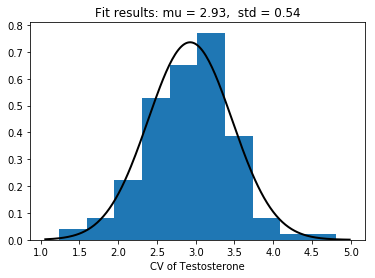

In [8]:
# Plot the PDF.
plt.hist(np.log(cv), normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p = norm.pdf(x, mu_log_cv, std_log_cv)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu_log_cv, std_log_cv)
plt.title(title)
plt.xlabel("CV of Testosterone")
plt.show()

### Gender specific CV distribution

In [9]:
mu_log_cv_male, std_log_cv_male = norm.fit(np.log(cv_male))
mu_log_cv_female, std_log_cv_female = norm.fit(np.log(cv_female))

## Mean distribution of Testosterone

mu1: 0.65, mu2: 2.31, sigma1: 0.32, sigma2: 0.48


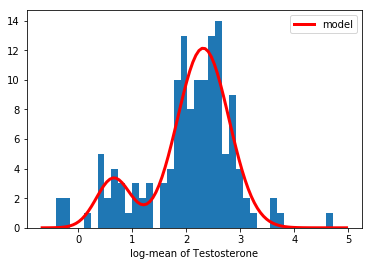

In [10]:
def bimodal(x, mu1, sigma1, a, mu2, sigma2, b):
    return a * norm.pdf(x, loc=mu1, scale=sigma1) + b * norm.pdf(x, loc=mu2, scale=sigma2)

y, x, _ = plt.hist(np.log(mean_std[:, 0]), bins=40)

x = (x[1:] + x[:-1]) / 2  # for len(x)==len(y)

expected = (.9, .3, 5, 2, .5, 25)
params, cov = curve_fit(bimodal, x, y, expected)

x_min, x_max = plt.xlim()
x_range = np.linspace(x_min, x_max, 100)

plt.plot(x_range, bimodal(x_range, *params), color='red', lw=3, label='model')
plt.xlabel("log-mean of Testosterone")

plt.legend()
print("mu1: %.2f, mu2: %.2f, sigma1: %.2f, sigma2: %.2f" % (params[0], params[3], params[1], params[4]))

### Gender Specific Mean Distribution

mu_log_mu_male: 2.393652448985088 
 std_log_mu_male: 0.4975949035276396 
 mu_log_mu_female: 0.7679896207224753 
 std_log_mu_female: 0.6064513206209803


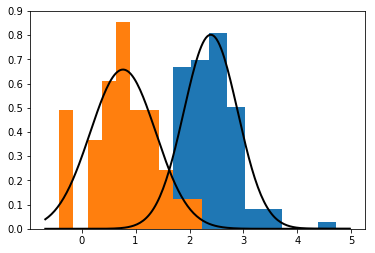

In [60]:
mu_log_mu_male, std_log_mu_male = norm.fit(np.log(mean_std_male[:, 0]))
mu_log_mu_female, std_log_mu_female = norm.fit(np.log(mean_std_female[:, 0]))

# Plot the PDF.
plt.hist(np.log(mean_std_male[:, 0]), normed=True)
plt.hist(np.log(mean_std_female[:, 0]), normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p_male = norm.pdf(x, mu_log_mu_male, std_log_mu_male)
p_female = norm.pdf(x, mu_log_mu_female, std_log_mu_female)
plt.plot(x, p_male, 'k', linewidth=2)
plt.plot(x, p_female, 'k', linewidth=2)
print("mu_log_mu_male:", mu_log_mu_male, "\n", "std_log_mu_male:", std_log_mu_male, "\n", "mu_log_mu_female:",
      mu_log_mu_female, "\n", "std_log_mu_female:", std_log_mu_female)
plt.show()

## $p (x _ { 1} ,x _ { 2} ,\dots ,x _ { n }, x _ { n + 1} ) = \iint \prod _ { j = 1} ^ { n + 1} N ( \mu ,\sigma ) | _ { x _ { j } } \cdot p ( \mu ,\sigma ) \, d\mu \, d\sigma$

In [12]:
def joint_prob(mu, sigma, mu_log_mu, std_log_mu, mu_log_cv, std_log_cv):
    
    cv = ( sigma / mu ) * 100
    
    log_mu = np.log(mu)
    log_cv = np.log(cv)

    p_mu = norm.pdf(log_mu, loc=mu_log_mu, scale=std_log_mu)
    p_cv = norm.pdf(log_cv, loc=mu_log_cv, scale=std_log_cv)

    return mu * p_cv * p_mu

def products(mu, sigma, observations):
    return np.product([norm.pdf(obs, loc=mu, scale=sigma) for obs in observations])

def dist(mu, sigma, observations, mu_log_mu, std_log_mu, mu_log_cv, std_log_cv):
    return products(mu, sigma, observations) * joint_prob(mu, sigma, mu_log_mu, std_log_mu,
                                                                      mu_log_cv, std_log_cv)

In [13]:
def p(x, observations): return dblquad(dist, 1, 30, lambda x: 1, lambda x: 5,
                         args=[np.append(observations[:-1], x), mu_log_mu_male, std_log_mu_male, mu_log_cv_male,
                               std_log_cv_male], points)[0]

## Evaluation of Joint Distribution

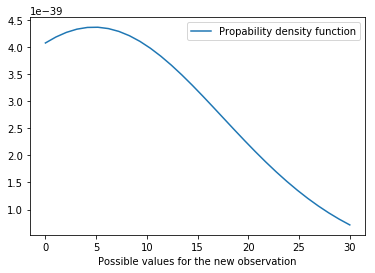

In [175]:
possible_new_observation = np.linspace(0, 30, 30)
pdf = [p(x, testosterones[49].values) for x in possible_new_observation]
plt.plot(possible_new_observation, pdf, label="Propability density function")
plt.xlabel("Possible values for the new observation")
plt.legend();

### Evaluation of CDF

In [162]:
interpolated_pdf = InterpolatedUnivariateSpline(possible_new_observation, pdf)
pdf_area = interpolated_pdf.integral(0, np.inf)
def cdf(x, pdf_area, interpolated_pdf): return interpolated_pdf.integral(0, x) / pdf_area

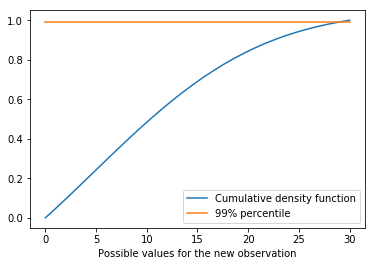

In [173]:
cdf_points = [cdf(x, pdf_area, interpolated_pdf) for x in possible_new_observation]
plt.plot(possible_new_observation, cdf_points, label="Cumulative density function")
plt.plot(possible_new_observation, np.repeat([.99], 30), label="99% percentile")
plt.xlabel("Possible values for the new observation")
plt.legend();

## Visualizing Density functions

In [155]:
# take a sample person and visualize based his observations
sample = testosterones[49].values

In [160]:
mu, sigma = np.linspace(1,50), np.linspace(1,10)
mu, sigma = np.meshgrid(mu, sigma)

joint_prob_z = joint_prob(mu, sigma,mu_log_mu_male, std_log_mu_male, mu_log_cv, std_log_cv)
products_z = np.array([products(mu, sigma, sample) for sigma in np.linspace(1,10) for mu in np.linspace(1,50)]).reshape(50,50)

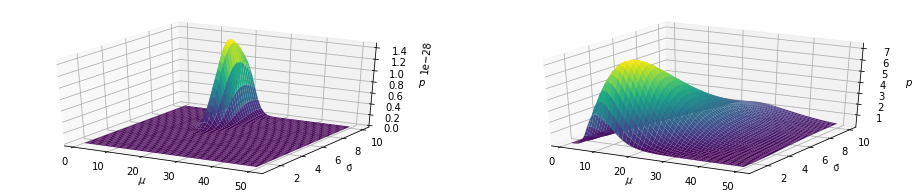

In [161]:
fig = plt.figure(figsize=(plt.figaspect(.2)));
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(mu, sigma, products_z, antialiased=True,cmap=cm.viridis)
ax.set_xlabel("$\mu$");
ax.set_ylabel("$\sigma$");
ax.set_zlabel("$p$");
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(mu, sigma, joint_prob_z, cmap=cm.viridis)
ax.set_xlabel("$\mu$");
ax.set_ylabel("$\sigma$");
ax.set_zlabel("$p$");